# Predicting NFL Playoff Success
By: Phil Cork & Allison Hansen

## Overview 

The goal of this project is to create and combine data tables related to team season statistics and relate them to the team's performance in the playoffs. 

There are 3 different datsets considered: 
- Spreadspoke Scores: Game results and Vegas betting data
- NFL Offense: Offense season statistics per team per year
- NFL Defense: Defense season statistics per team per year


## Goals 

To predict the team's performance in the playoffs related to the progressive rounds of games they compete in. 


## Load data, clean, and create table

In [1]:
# import libraries and helpful functions 

import pandas as pd 
import numpy as np

import sklearn.model_selection as model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import datetime as datetime
from sklearn.decomposition import PCA 

from sklearn.metrics import classification_report 

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_1 = 'spreadspoke_scores.csv'
spreadspoke_scores = pd.read_csv(file_1)

# only keep the playoff games
spreadspoke_scores = spreadspoke_scores[spreadspoke_scores.schedule_playoff == True]

# only keep games from 1988 onward which have 16 games seasons
spreadspoke_scores = spreadspoke_scores[spreadspoke_scores.schedule_season > 1987]

# set the date to be a datetime object
spreadspoke_scores['schedule_date'] = pd.to_datetime(spreadspoke_scores['schedule_date'])

# drop weather data since it is missing for too many games to accurately impute,
# especially given the variety in locations of stadiums
spreadspoke_scores = spreadspoke_scores.drop(['team_favorite_id','spread_favorite',
                                              'over_under_line','weather_temperature', 'weather_wind_mph',
                                              'weather_humidity','weather_detail', 'stadium','stadium_neutral'],axis=1)


In [3]:
# since spreadspoke_scores is one game per row, split the games into the two respective teams
home_team = spreadspoke_scores[['team_home','schedule_season','schedule_week']]
away_team = spreadspoke_scores[['team_away','schedule_season','schedule_week']]

# rename the columns in each dataset for merging
home_team.rename(columns={'team_home':'team','schedule_season':'season','schedule_week':'playoff'}, inplace=True)
away_team.rename(columns={'team_away':'team','schedule_season':'season','schedule_week':'playoff'}, inplace=True)

# combine the two datasets into one
teams = pd.concat([home_team, away_team])

# correct spelling inconsistencies
teams['playoff'] = np.where(teams['playoff']=='WildCard','Wildcard', teams['playoff'])
teams['playoff'] = np.where(teams['playoff']=='SuperBowl','Superbowl', teams['playoff'])

teams.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,team,season,playoff
4674,Cleveland Browns,1988,Wildcard
4675,Minnesota Vikings,1988,Wildcard
4676,Chicago Bears,1988,Division
4677,Cincinnati Bengals,1988,Division
4678,Buffalo Bills,1988,Division


In [4]:
file_2 = 'nfl_offense.csv'
offense = pd.read_csv(file_2)

# dropping columns that aren't consistent over the years or meaningful for this test
offense = offense.drop(['Rk','G','Sc%', 'TO%', 'EXP'], axis=1)

offense.rename(columns = { 'Year':'season','Tm':'team','Yds':'TYards', '1stD':'T1stD',
                           'Att':'PAtt', 'Yds.1':'PYds',
                           'TD':'PTD', 'NY/A':'P.NY/A',
                           '1stD.1':'P1stD', 'Att.1':'RAtt',
                           'Yds.2':'RYds', 'TD.1':'RTD',
                           'Y/A':"R.Y/A", '1stD.2':'R1stD',
                           'Yds.3':'PenYds', '1stPy':'Pen1stD'
                           }, inplace = True)

In [5]:
file_3 = 'nfl_defense.csv'
defense = pd.read_csv(file_3)

# dropping columns that aren't consistent over the years or meaningful for this test
defense = defense.drop(['Rk','G','opp_Sc%','opp_TO%','opp_EXP'], axis=1)

# rename attributes for merging
defense.rename(columns = {'Year':'season','Tm':'team'}, inplace = True)

In [6]:
# merge offense and defense data together based on the team and the year
teams = teams.merge(offense, how='inner', on=['season','team'])
teams = teams.merge(defense, how='inner', on=['season','team'])
teams.head()

,team,season,playoff,PF,TYards,Ply,Y/P,TO,FL,T1stD,...,opp_NPY/A,opp_P1stD,opp_RAtt,opp_RYds,opp_RTD,opp_RY/A,opp_R1stD,opp_Pen,opp_PenYds,opp_1stPy
0,Cleveland Browns,1988,Wildcard,304,5011,1013,4.9,33,16,294,...,5.6,162.0,498.0,1920.0,13.0,3.9,114.0,100.0,789.0,25.0
1,Minnesota Vikings,1988,Wildcard,406,5595,1068,5.2,30,12,318,...,4.8,132.0,435.0,1602.0,10.0,3.7,85.0,91.0,753.0,26.0
2,Minnesota Vikings,1988,Division,406,5595,1068,5.2,30,12,318,...,4.8,132.0,435.0,1602.0,10.0,3.7,85.0,91.0,753.0,26.0
3,Chicago Bears,1988,Division,312,5317,1040,5.1,34,19,303,...,5.2,158.0,389.0,1326.0,5.0,3.4,76.0,102.0,804.0,30.0
4,Chicago Bears,1988,Conference,312,5317,1040,5.1,34,19,303,...,5.2,158.0,389.0,1326.0,5.0,3.4,76.0,102.0,804.0,30.0


In [7]:
# one hot encode playoff games 

teams = pd.concat([teams,pd.get_dummies(teams['playoff'], prefix='playoff')],axis=1)
teams.drop(['playoff'],axis=1, inplace=True)

In [8]:
# Currently the teams dataset includes multiple rows with the same seasonal data with 
# each binary output for each week of the playoffs in a different row.
# Thus, we separate each tier of playoffs into its own dataset, then merge them together to make sure
# each binary output ends up in one row to represent each team in each year exactly once

wild = teams[['team','season','playoff_Wildcard']]
div = teams[['team','season','playoff_Division']]
conf = teams[['team','season','playoff_Conference']]
sb = teams[['team','season','playoff_Superbowl']]

playoffs = wild.merge(div, how='left', on=['team','season'])
playoffs = playoffs.merge(conf, how='left', on=['team','season'])
playoffs = playoffs.merge(sb, how='left', on=['team','season'])
playoffs['sum'] = playoffs['playoff_Wildcard'] + playoffs['playoff_Division'] + playoffs['playoff_Conference'] + playoffs['playoff_Superbowl']
playoffs

# drop duplicates now that all of the data is merged together, keeping the row with the most data.
playoffs = playoffs.sort_values('sum').drop_duplicates(["team","season"],keep='last')
playoffs = playoffs.sort_values('season')
playoffs.head()

,team,season,playoff_Wildcard,playoff_Division,playoff_Conference,playoff_Superbowl,sum
5,Minnesota Vikings,1988,1,1,0,0,2
9522,Seattle Seahawks,1988,0,1,0,0,1
117,Buffalo Bills,1988,0,1,1,0,2
9521,Philadelphia Eagles,1988,0,1,0,0,1
19,Chicago Bears,1988,0,1,1,0,2


In [9]:
# now that the playoff data is properly processed so each row represents a team's entire playoff performance,
# we now have to remove the outdated means of displaying the playoffs and reconnect the playoff and seasonal data.

teamsmerge = teams.drop(['playoff_Conference', 
                         'playoff_Division', 
                         'playoff_Superbowl', 
                         'playoff_Wildcard'], axis=1)

merged_left = pd.merge(left=playoffs, 
                       right=teamsmerge, 
                       how='left', 
                       on=['season','team'])

merged_left.head()

teamsfinal = merged_left.drop_duplicates(subset=['team','season'])
teamsfinal.head()

,team,season,playoff_Wildcard,playoff_Division,playoff_Conference,playoff_Superbowl,sum,PF,TYards,Ply,...,opp_NPY/A,opp_P1stD,opp_RAtt,opp_RYds,opp_RTD,opp_RY/A,opp_R1stD,opp_Pen,opp_PenYds,opp_1stPy
0,Minnesota Vikings,1988,1,1,0,0,2,406,5595,1068,...,4.8,132.0,435.0,1602.0,10.0,3.7,85.0,91.0,753.0,26.0
2,Seattle Seahawks,1988,0,1,0,0,1,339,4842,983,...,6.3,171.0,509.0,2286.0,14.0,4.5,134.0,111.0,861.0,16.0
3,Buffalo Bills,1988,0,1,1,0,2,329,5315,1012,...,5.5,146.0,477.0,1854.0,14.0,3.9,114.0,90.0,713.0,39.0
5,Philadelphia Eagles,1988,0,1,0,0,1,379,5430,1102,...,6.7,199.0,466.0,1652.0,11.0,3.5,85.0,115.0,897.0,27.0
6,Chicago Bears,1988,0,1,1,0,2,312,5317,1040,...,5.2,158.0,389.0,1326.0,5.0,3.4,76.0,102.0,804.0,30.0


## Prepare table for predictions 

In [10]:
# create columns for predicting wins

teamsfinal['division_win'] = np.where(teamsfinal['playoff_Conference']==1, 1, 0)

teamsfinal['conference_win'] = np.where(teamsfinal['playoff_Superbowl']==1, 1, 0)

teamsfinal.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,team,season,playoff_Wildcard,playoff_Division,playoff_Conference,playoff_Superbowl,sum,PF,TYards,Ply,...,opp_RAtt,opp_RYds,opp_RTD,opp_RY/A,opp_R1stD,opp_Pen,opp_PenYds,opp_1stPy,division_win,conference_win
0,Minnesota Vikings,1988,1,1,0,0,2,406,5595,1068,...,435.0,1602.0,10.0,3.7,85.0,91.0,753.0,26.0,0,0
2,Seattle Seahawks,1988,0,1,0,0,1,339,4842,983,...,509.0,2286.0,14.0,4.5,134.0,111.0,861.0,16.0,0,0
3,Buffalo Bills,1988,0,1,1,0,2,329,5315,1012,...,477.0,1854.0,14.0,3.9,114.0,90.0,713.0,39.0,1,0
5,Philadelphia Eagles,1988,0,1,0,0,1,379,5430,1102,...,466.0,1652.0,11.0,3.5,85.0,115.0,897.0,27.0,0,0
6,Chicago Bears,1988,0,1,1,0,2,312,5317,1040,...,389.0,1326.0,5.0,3.4,76.0,102.0,804.0,30.0,1,0


In [11]:
teamsfinal.shape

(380, 53)

In [12]:
teamsfinal.columns

Index(['team', 'season', 'playoff_Wildcard', 'playoff_Division',
       'playoff_Conference', 'playoff_Superbowl', 'sum', 'PF', 'TYards', 'Ply',
       'Y/P', 'TO', 'FL', 'T1stD', 'Cmp', 'PAtt', 'PYds', 'PTD', 'Int',
       'P.NY/A', 'P1stD', 'RAtt', 'RYds', 'RTD', 'R.Y/A', 'R1stD', 'Pen',
       'PenYds', 'Pen1stD', 'opp_PF', 'opp_TYds', 'opp_TPly', 'opp_TY/P',
       'opp_TO', 'opp_FL', 'opp_T1stD', 'opp_Cmp', 'opp_PAtt', 'opp_PYds',
       'opp_PTD', 'opp_Int', 'opp_NPY/A', 'opp_P1stD', 'opp_RAtt', 'opp_RYds',
       'opp_RTD', 'opp_RY/A', 'opp_R1stD', 'opp_Pen', 'opp_PenYds',
       'opp_1stPy', 'division_win', 'conference_win'],
      dtype='object')

## Test Classification Algorithms 

## Predicting Advancing to Conference Game, Decision Tree: 
Node Depth 4, Accuracy of 0.60

In [13]:
# predicting advancing to conference game using a Decision Tree

x = teamsfinal.drop(['team',
                     'sum',
                     'playoff_Wildcard', 
                     'playoff_Division',
                     'playoff_Conference', 
                     'playoff_Superbowl', 
                     'division_win', 
                     'conference_win'], axis=1)

y = teamsfinal['playoff_Conference']

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
                                                                    train_size=0.8, 
                                                                    test_size=0.2, 
                                                                    random_state=101)

dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

dtree.fit(x_train, y_train)

predTree = dtree.predict(x_test)

treeAccuracy = metrics.accuracy_score(y_test, predTree)

print("Decision Trees's Accuracy: ", treeAccuracy)

print(classification_report(y_test, predTree))

Decision Trees's Accuracy:  0.6973684210526315
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        55
           1       0.43      0.29      0.34        21

    accuracy                           0.70        76
   macro avg       0.59      0.57      0.57        76
weighted avg       0.67      0.70      0.68        76



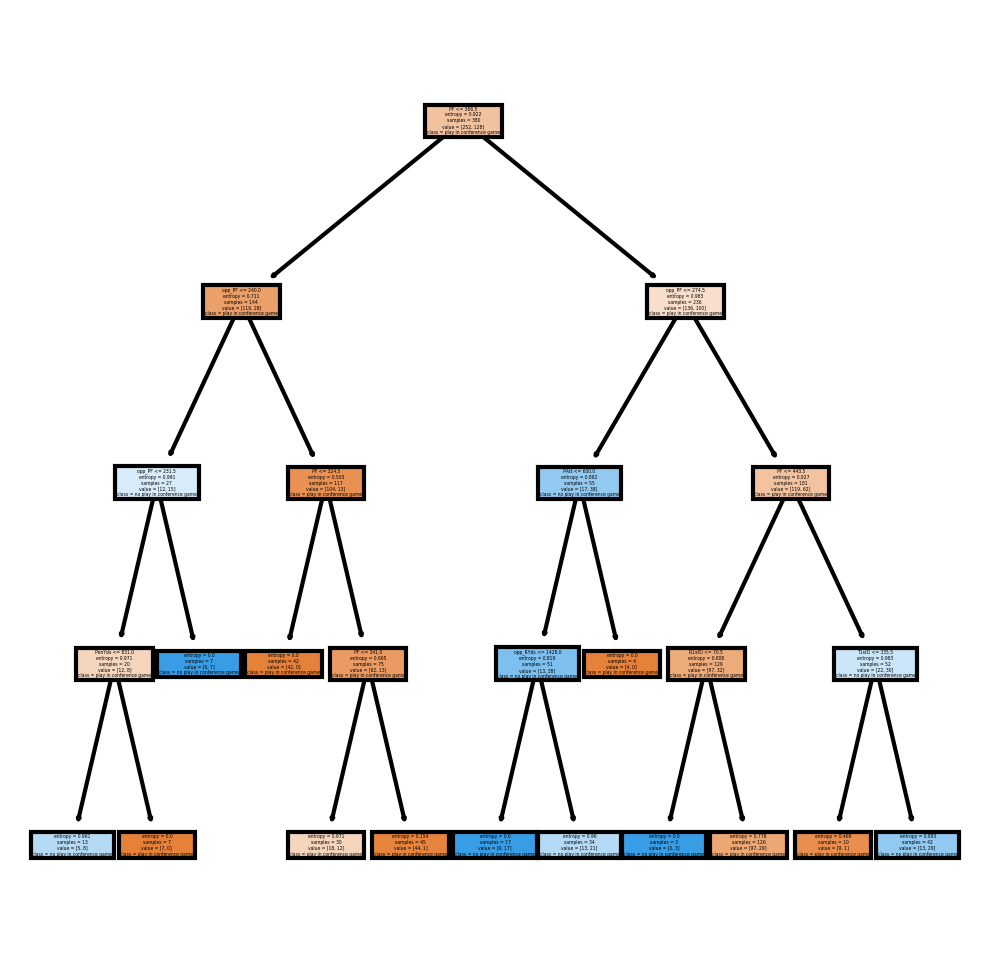

In [14]:
# Plot the Decision Tree

fn = ['season', 'PF', 'TYards', 'Ply',
       'Y/P', 'TO', 'FL', 'T1stD', 'Cmp', 'PAtt', 'PYds', 'PTD', 'Int',
       'P.NY/A', 'P1stD', 'RAtt', 'RYds', 'RTD', 'R.Y/A', 'R1stD', 'Pen',
       'PenYds', 'Pen1stD', 'opp_PF', 'opp_TYds', 'opp_TPly', 'opp_TY/P',
       'opp_TO', 'opp_FL', 'opp_T1stD', 'opp_Cmp', 'opp_PAtt', 'opp_PYds',
       'opp_PTD', 'opp_Int', 'opp_NPY/A', 'opp_P1stD', 'opp_RAtt', 'opp_RYds',
       'opp_RTD', 'opp_RY/A', 'opp_R1stD', 'opp_Pen', 'opp_PenYds',
       'opp_1stPy']

cn = ['play in conference game', 'no play in conference game']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dtree.fit(x,y),
               feature_names = fn, 
               class_names = cn,
               filled = True);
fig.savefig('data.png')

## Predicting Advancing to Conference Game with PCA
Decision Tree using PCA 5 Components, Node Depth 4, Accuracy of 0.64

In [15]:
# predicting advancing to conference game with PCA 

x = teamsfinal.drop(['team',
                     'sum',
                     'playoff_Wildcard', 
                     'playoff_Division',
                     'playoff_Conference', 
                     'playoff_Superbowl', 
                     'division_win', 
                     'conference_win'], axis=1)

y = teamsfinal['playoff_Conference']

pca = PCA(n_components=5)

pca = pca.fit(x)

x = pca.transform(x)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
                                                                    train_size=0.8, 
                                                                    test_size=0.2, 
                                                                    random_state=101)

dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

dtree.fit(x_train, y_train)

predTree = dtree.predict(x_test)

treeAccuracy = metrics.accuracy_score(y_test, predTree)

# pca 1 = 0.6097560975609756
# pca 2 = 0.5487804878048781
# pca 3 = 0.5487804878048781
# pca 4 = 0.5853658536585366
### pca 5 = 0.6463414634146342
# pca 6 = 0.6463414634146342
# pca 7 = 0.6463414634146342
# pca 8 = 0.6463414634146342
# pca 9 = 0.6463414634146342
# pca 10 = 0.6463414634146342

print("Decision Tree with PCA Accuracy: ", treeAccuracy)
print('\n')
print("Classification Report:")
print('\n')
print(classification_report(y_test, predTree))
print('\n')

Decision Tree with PCA Accuracy:  0.6842105263157895


Classification Report:


              precision    recall  f1-score   support

           0       0.77      0.80      0.79        55
           1       0.42      0.38      0.40        21

    accuracy                           0.68        76
   macro avg       0.60      0.59      0.59        76
weighted avg       0.67      0.68      0.68        76





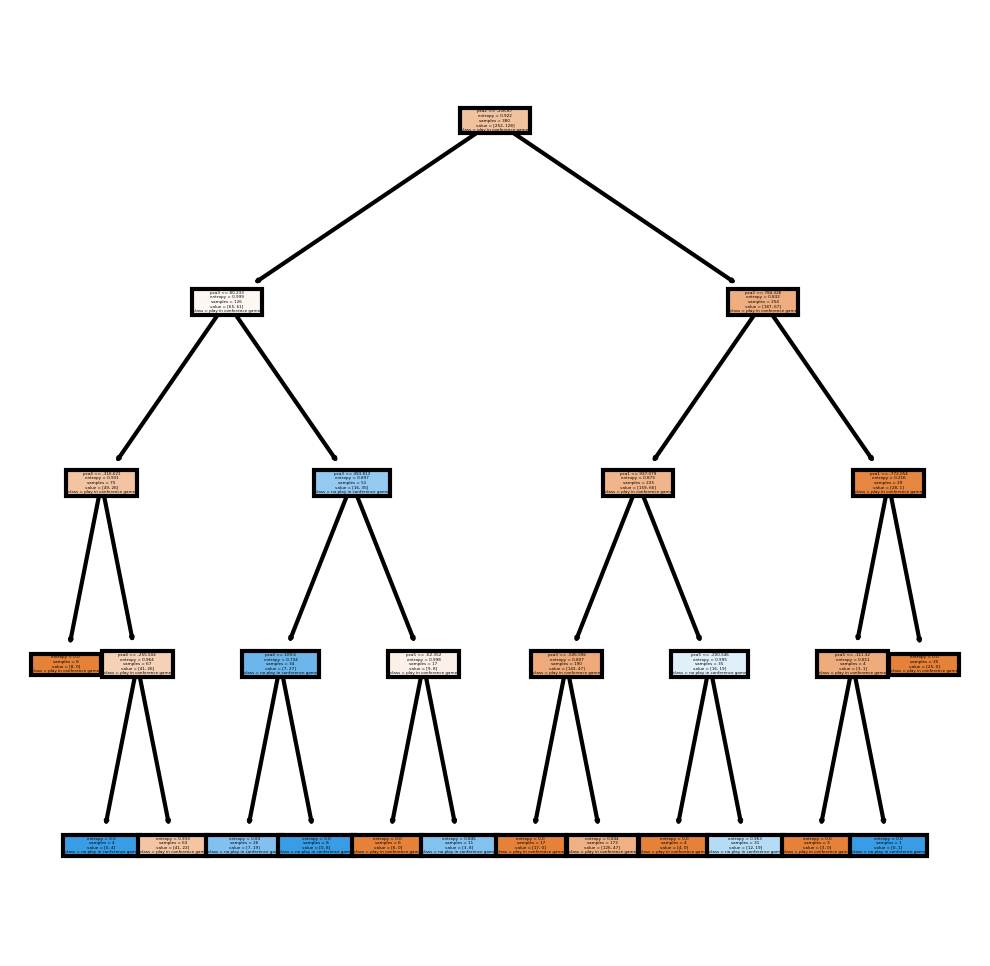

In [16]:
fn = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5']
cn = ['play in conference game', 'no play in conference game']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dtree.fit(x,y),
               feature_names = fn, 
               class_names = cn,
               filled = True);
fig.savefig('data.png')

## Predicting Advancing to Conference Game, Random Forest
Random Forest, Node Depth 4, Accuracy of 0.64

In [17]:
x = teamsfinal.drop(['team',
                     'sum',
                     'playoff_Wildcard', 
                     'playoff_Division',
                     'playoff_Conference', 
                     'playoff_Superbowl',
                     'division_win', 
                     'conference_win'], axis=1)

y = teamsfinal['playoff_Conference']

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
                                                                    train_size=0.8, 
                                                                    test_size=0.2, 
                                                                    random_state=101)

rtree = RandomForestClassifier(criterion="entropy", max_depth = 4)

rtree.fit(x_train, y_train)

predTree = rtree.predict(x_test)

treeAccuracy = metrics.accuracy_score(y_test, predTree)

print("Random Forest Trees's Accuracy: ", treeAccuracy)
print(classification_report(y_test,predTree))


Random Forest Trees's Accuracy:  0.7236842105263158
              precision    recall  f1-score   support

           0       0.77      0.89      0.82        55
           1       0.50      0.29      0.36        21

    accuracy                           0.72        76
   macro avg       0.63      0.59      0.59        76
weighted avg       0.69      0.72      0.70        76



### Predicting Advancing to Conference Game, Random Forest with PCA: 

In [18]:
# predicting advancing to conference game with random forest with PCA 

x = teamsfinal.drop(['team',
                     'sum',
                     'playoff_Wildcard', 
                     'playoff_Division',
                     'playoff_Conference', 
                     'playoff_Superbowl',
                     'division_win', 
                     'conference_win'], axis=1)

y = teamsfinal['playoff_Conference']

pca = PCA(n_components=4)

pca = pca.fit(x)

x = pca.transform(x)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
                                                                    train_size=0.8, 
                                                                    test_size=0.2, 
                                                                    random_state=101)

rtree = RandomForestClassifier(criterion="entropy", max_depth = 4)

rtree.fit(x_train, y_train)

predTree = rtree.predict(x_test)

treeAccuracy = metrics.accuracy_score(y_test, predTree)

print("Random Forest Trees's Accuracy: ", treeAccuracy)

Random Forest Trees's Accuracy:  0.7105263157894737


## Analysis & Takeaways

On the whole, we were unsurprised to find it's easier to predict teams that *don't* make it further into the playoffs than it is to accurate predict which teams will ultimately contend for the Lombardi trophy, but we were pleased to see our overall accuracy improve over the process of our experiments. Further, while there is no silver bullet attribute hidden in the offensive or defensive data we collected which can predict playoff success singularly, it speaks to the nuance and multiple-faceted nature of the game that when the components are combined, our model gains a better graps of who the playoffs might shake out.

Throughout the process, our takeways regarding the project itself involved the interesting challenges we faced in dealing with data leakage and overfitting our models when initially trying to predict game outcomes instead of playoff progression. The process of reframing our question while limited by the data we had access to served as what we felt was a real-life authentic experience of using imperfect data to arrive at a meaningful and insightful destination, even if it was not the one we initially intended. With this iteration of the project complete, we already have a myriad of ideas as to how to further improve our models and the datasets they are built upon in future endeavors.